In [1]:
%matplotlib inline


In [2]:
from visualizations.embeddings import plot_embeddings_of_rotated_image, visualise_dimreduced_embeddings
from visualizations.feature_maps import plot_group_feature_maps
from visualizations.spatial_transform_grid import visualize_transform_grid, visualise_digit_transform


In [3]:
input_config = {
    "C": 1,
    "H": 28,
    "W": 28
}

output_config = {
    "C": 10
}


In [4]:
experiment_config = {
    "batch_size": 32,
    "max_epochs": 20,
    "log_every_n_steps": 100,
    "patience": 5,
    "rotate_train": False,
    "rotate_test": True,
    "seed": 420,
    "runs": 3,
}

optimizer_hparams = {
    "lr": 1e-2,
    "weight_decay": 1e-4
}


In [5]:
import torch
import pytorch_lightning as pl
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

pl.seed_everything(experiment_config["seed"], workers=True)


Global seed set to 420


420

In [6]:
datasets_root_path = "./datasets"


In [7]:
from loaders import get_loaders

train_loader, val_loader, test_loader = get_loaders(
    datasets_root_path=datasets_root_path,
    experiment_config=experiment_config
)


In [8]:
from groups.discrete_so2 import DiscreteSO2


model_name = "GCNN"
model_hparams = {
    "in_channels": input_config["C"],
    "out_channels": output_config["C"],
    "kernel_size": 5,
    "gconv_layers": 4,
    "channels": 32,
    "group": DiscreteSO2(order=4)
}


In [9]:
target_checkpoint = "results/no-rotations/gcnns/checkpoint-run=3-GCNN-order=4-gconv_layers=4-channels=32-kernel_size=5-batch_size=32-lr=0.01-weight_decay=0.0001-max-epochs=20-seed=420.ckpt"


In [10]:
from torchinfo import summary
from modules.MNISTModule import MNISTModule


module = MNISTModule(model_name, model_hparams,
                     optimizer_hparams).load_from_checkpoint(target_checkpoint)
summary(
    module.model,
    input_size=(
        experiment_config["batch_size"],
        input_config["C"],
        input_config["H"],
        input_config["W"],
    )
)


/Users/gboduljak/.local/share/virtualenvs/geometric-deep-learning-7fBP83ZS/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/gboduljak/.local/share/virtualenvs/geometric-deep-learning-7fBP83ZS/lib/python3.9/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
GroupEquivariantCNN                      [32, 10]                  --
├─LiftingConvBlock: 1-1                  [32, 32, 4, 26, 26]       --
│    └─LiftingConv: 2-1                  [32, 32, 4, 26, 26]       800
├─ModuleList: 1-8                        --                        (recursive)
│    └─GroupConvBlock: 2-2               [32, 32, 4, 22, 22]       --
│    │    └─GroupConv: 3-1               [32, 32, 4, 22, 22]       102,400
├─ModuleList: 1-7                        --                        --
│    └─GroupSpatialMaxPool: 2-3          [32, 32, 4, 21, 21]       --
├─ModuleList: 1-8                        --                        (recursive)
│    └─GroupConvBlock: 2-4               [32, 32, 4, 17, 17]       --
│    │    └─GroupConv: 3-2               [32, 32, 4, 17, 17]       102,400
├─ModuleList: 1-7                        --                        --
│    └─GroupSpatialMaxPool: 2-5          [32, 32, 4, 16,

In [11]:
from trainer import get_trainer
tester = get_trainer(experiment_config)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gboduljak/.local/share/virtualenvs/geometric-deep-learning-7fBP83ZS/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [12]:
tester.test(module, test_loader)


/Users/gboduljak/.local/share/virtualenvs/geometric-deep-learning-7fBP83ZS/lib/python3.9/site-packages/lightning_fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
/Users/gboduljak/.local/share/virtualenvs/geometric-deep-learning-7fBP83ZS/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9362999796867371
        test_loss           0.20682461559772491
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.20682461559772491, 'test_acc': 0.9362999796867371}]

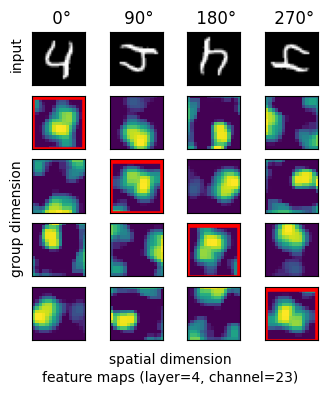

In [13]:


plot_group_feature_maps(
    module.model,
    layer=4,
    target_image=4,  # 16
    target_channel=23
)


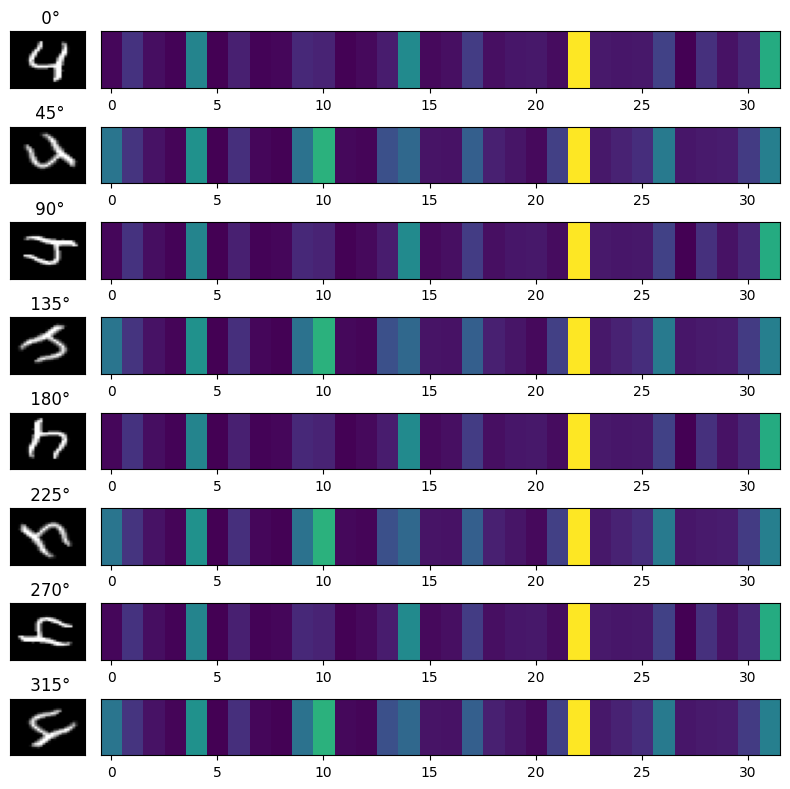

In [14]:


plot_embeddings_of_rotated_image(
    module.model,
    target_image=4,
    num_rotations=8
)


<Figure size 800x800 with 0 Axes>

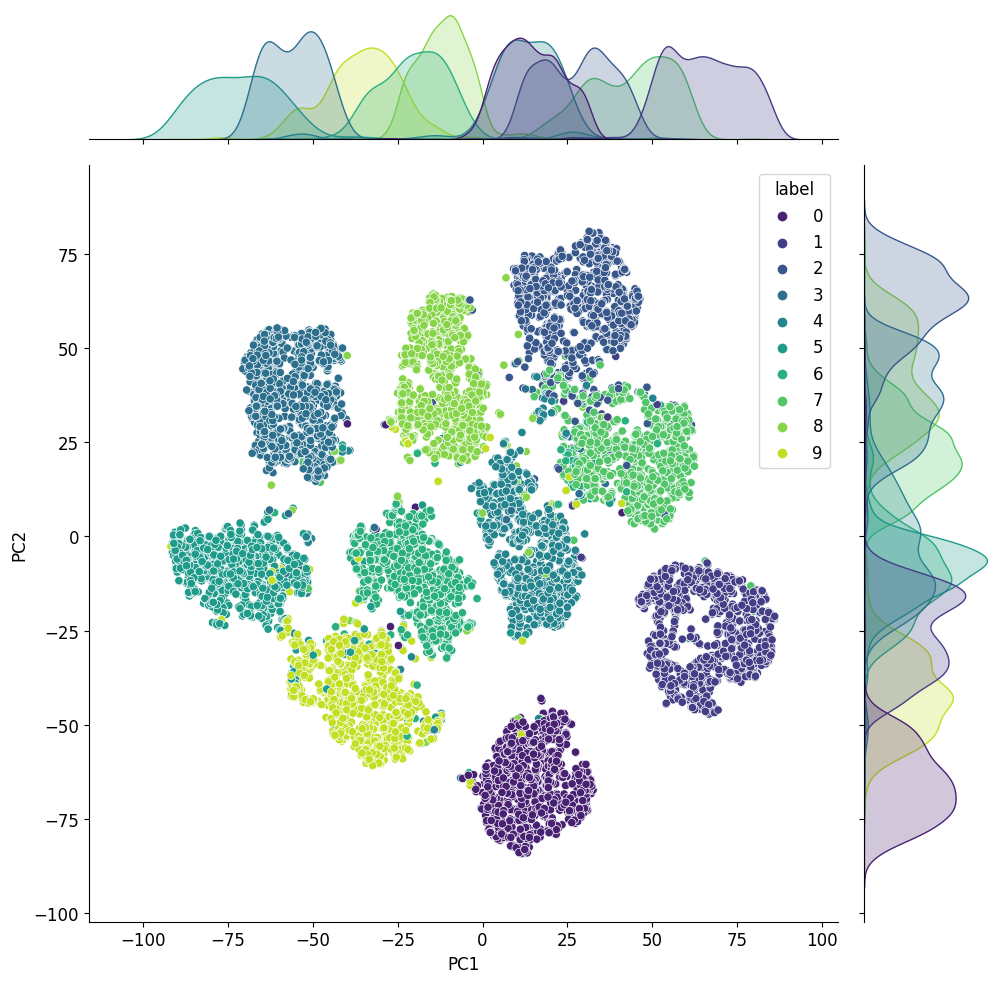

In [15]:
visualise_dimreduced_embeddings(
    model=module.model,
    loader=test_loader
)
